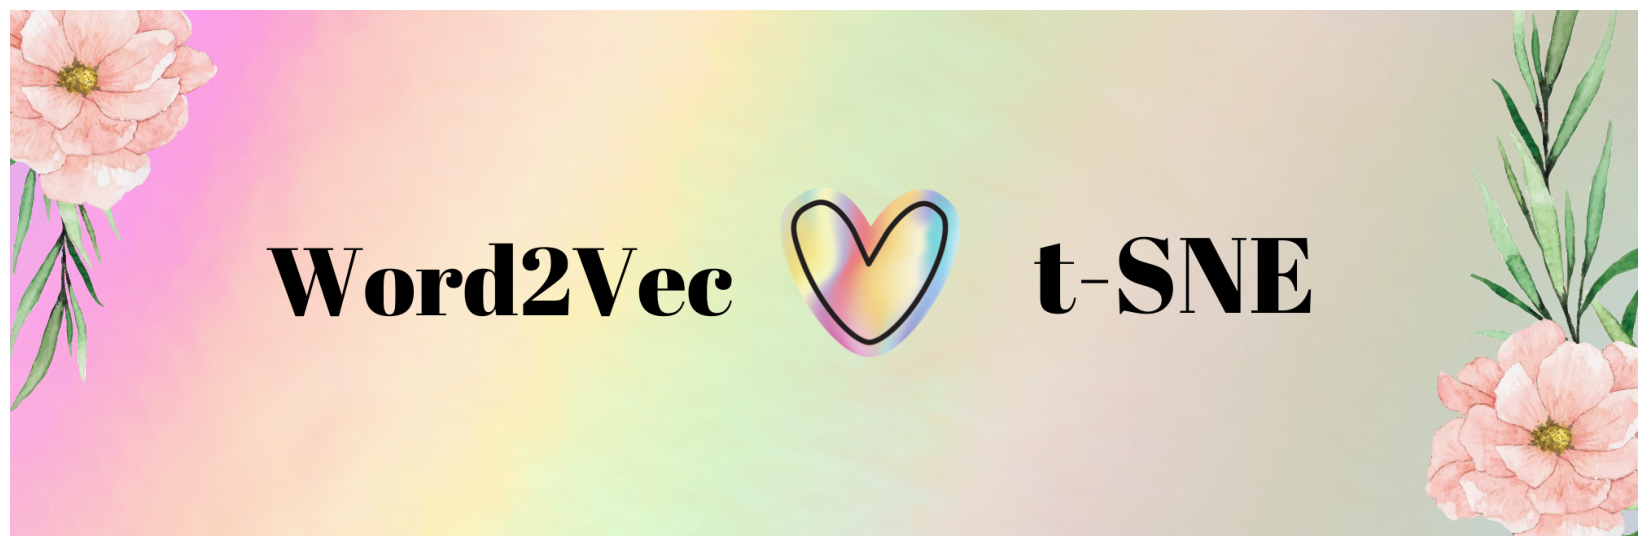

In [4]:
import PIL
import urllib
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(21,7))
plt.axis(False)
plt.imshow(
    np.array(
        PIL.Image.open(
            urllib.request.urlopen(
                "https://user-images.githubusercontent.com/57945364/172929241-15296cd2-2441-45ce-b6ac-b286c80bc29f.png"
            )
        )
    )
)

<a id="prac"></a>
# **Embedding OWL ontologies with OWL2Vec**

OWL2Vec* is a state-of-the-art system that creates embeddings for both the entities and the lexical information that appears in an ontology. We have explored  embedding configurations by varying the hyperparameters of OWL2Vec*.
Our input data is a domain ontology of psychiatry developed as part of the PsyCARE project serves more purposes than just TALN; in particular, it serves as a general interoperability model of the project. The ontology used has 44,272 classes split into three branches: biological process (28,922 classes), molecular function (11,157 classes), cellular component (4,193 classes). We use OWL2Vec* to create embeddings which are later clustered by K-means and visulized by t-sne.

<a id="prac"></a>
# **Practical implementation**
## 1. Scraped - clean - embed - visualize

Imports

In [2]:
!pip install gensim

In [3]:
import re
import nltk
import bs4 as bs
import numpy as np
import urllib.request
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from gensim.models import word2vec

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

<a id="c2"></a>
## 2. Embed - visualize - experiment

As an input data for visualization, we will use articles from Google News and a few novels by Leo Tolstoy. Pre-trained vectors trained on part of Google News dataset (about 100 billion words) was published by Google at the [official page](https://code.google.com/archive/p/word2vec/), so we will use it.

Imports

In [5]:
import gensim.downloader as api
from sklearn.manifold import TSNE
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
#wv = api.load('/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/w2v-fr/wiki+medical_model.word2vec')
wv = Word2Vec.load("/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/cache/output_fr/ontology.embeddings")

In [7]:
word_vectors = wv.wv
print(word_vectors["schizophrénie"])

[ 0.00758294  0.2395544   0.33168587  0.63922966 -0.523911    0.36865777
  1.1672872   0.4535041  -0.2031541  -1.2154604   0.26554158 -1.5444498
  0.20878538 -0.99140686  1.8024784  -0.0383212   0.6935638   0.0258398
  0.14027053 -1.0108528   0.5448285   0.26925775 -0.30937892  0.55664176
 -0.9319155  -0.15032306 -0.0170061   0.24584955 -0.6012007   0.13094477
 -0.38148236 -0.41735843  0.31319407  0.55694515  1.0140091  -0.02412622
 -0.7761232  -0.29066744 -0.6856034  -0.26693326 -0.51927346  0.26253158
 -1.2475852  -0.96253103  0.30484074 -0.83836216 -0.66481066 -0.18165585
 -1.0363283   0.22787881 -1.507525   -0.5313266   0.41514015  0.2775238
  1.0303514  -0.34246036  0.24416377  0.00515891 -0.7720882  -0.45888308
  0.5819749  -0.9945376   0.4291288   0.09970108 -0.3404172  -0.237361
  1.5234611   0.05158111 -0.01099504 -0.01087873  0.2401108  -0.06897415
  0.70368403  0.0745537  -1.342923   -0.1307713  -0.60888803 -0.8828865
 -0.32420102 -0.4038518   0.22902516  0.58683455 -0.10358

In [10]:
# Lets check dimension of our vector
#wv["schizophrénie"].shape
word_vectors["schizophrénie"].shape

(100,)

Let's check if it works..

In [15]:
# Check for the similar words
wv.wv.most_similar("schizophrénie")

[('indifférenciée', 0.7647144198417664),
 ('http://data.esante.gouv.fr/atih/cim10/F20.8', 0.7578268051147461),
 ('http://data.esante.gouv.fr/atih/cim10/F20.9', 0.7476665377616882),
 ('schizophréniforme', 0.7462497353553772),
 ('http://data.esante.gouv.fr/atih/cim10/F20.6', 0.745433509349823),
 ('cénestopathique', 0.7415112853050232),
 ('rémittente', 0.7367889285087585),
 ('http://data.esante.gouv.fr/atih/cim10/F20.0', 0.7361388206481934),
 ('incomplète', 0.7347137928009033),
 ('http://data.esante.gouv.fr/atih/cim10/F20.3', 0.7321473956108093)]

Oh it very well does work. The outputs are quiet impressively accurate too. 

Lets jump into visualization:
Here we select our classes from the ontoogy to check their representation

In [21]:
# Select few keys 
keys = ['http://www.limics.fr/ontologies/ontoPOF#SituationTemporelle',"http://www.limics.fr/ontologies/ontoDOME#PartieDuCorps",'http://www.limics.fr/ontologies/ontoDOME#PortionDeSubstanceChimique','http://www.limics.fr/ontologies/ontoDOME#ProblemeDeSante', 'http://www.limics.fr/ontologies/ontoDOPSY#EvenementVecu', 'http://www.limics.fr/ontologies/ontoDOME#EpisodeDeSoin',"http://www.limics.fr/ontologies/ontoDOME#ReleveDExamen", 'http://www.limics.fr/ontologies/ontoDOME#SigneClinique', 'http://www.limics.fr/ontologies/ontoPOF#Qualite']
relkeys=['http://www.limics.fr/ontologies/ontoPOF#qualifie','http://www.limics.fr/ontologies/ontoPOF#porteSur',"http://www.limics.fr/ontologies/ontoPOF#participeA","http://www.limics.fr/ontologies/ontoPOF#estSujetDe","http://www.limics.fr/ontologies/ontoDOME#aDateSpecifique","http://www.limics.fr/ontologies/ontoDOME#cause"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    
    # Get and store similar words and their vectors
    similar_words = wv.wv.most_similar(word, topn=30)
    for similar_word, _ in similar_words:
        words.append(similar_word)
        embeddings.append(wv.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


In [22]:
embedding_clusters = np.array(embedding_clusters)
# Eembedding_clusters is a 3D array
    # dim 1: all the words in rows
    # dim 2: the clumns are filled with the similar words
    # dim 3: the vectr of length 300
    
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

Plot

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/2870537040.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


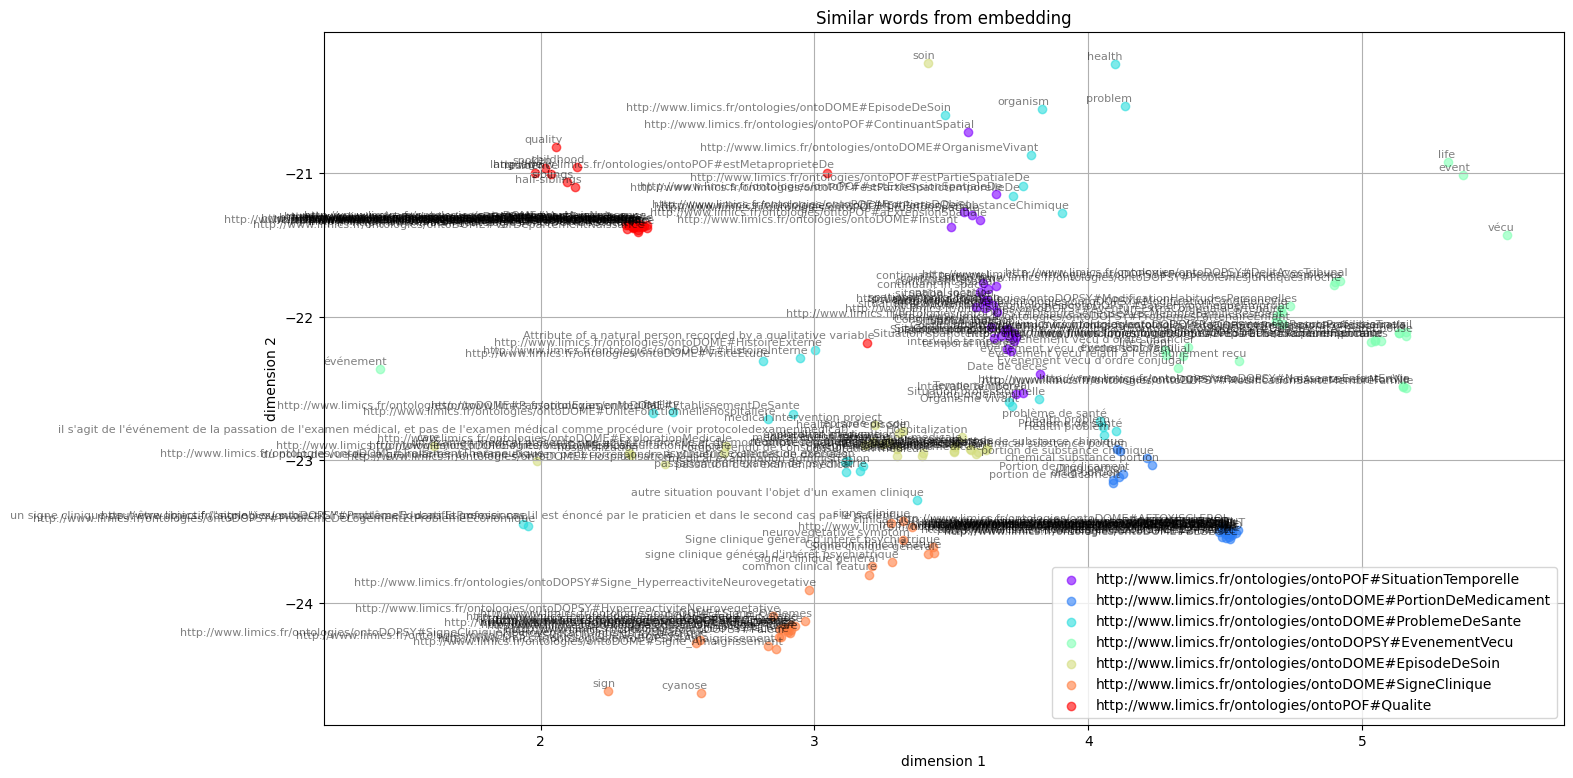

In [36]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from embedding', keys, embeddings_en_2d, word_clusters, 0.6,
                        'similar_words.png')

Isn't it fascinating to see how t-SNE reduces the dimension from 300 to 2 by retaining the cluster property this accurately! 😍😍😍 

(Note🧘: Well, the results might vary depending on the data. It is important to know your data to apply correct dimensionality model to get great outputs)

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/776697479.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


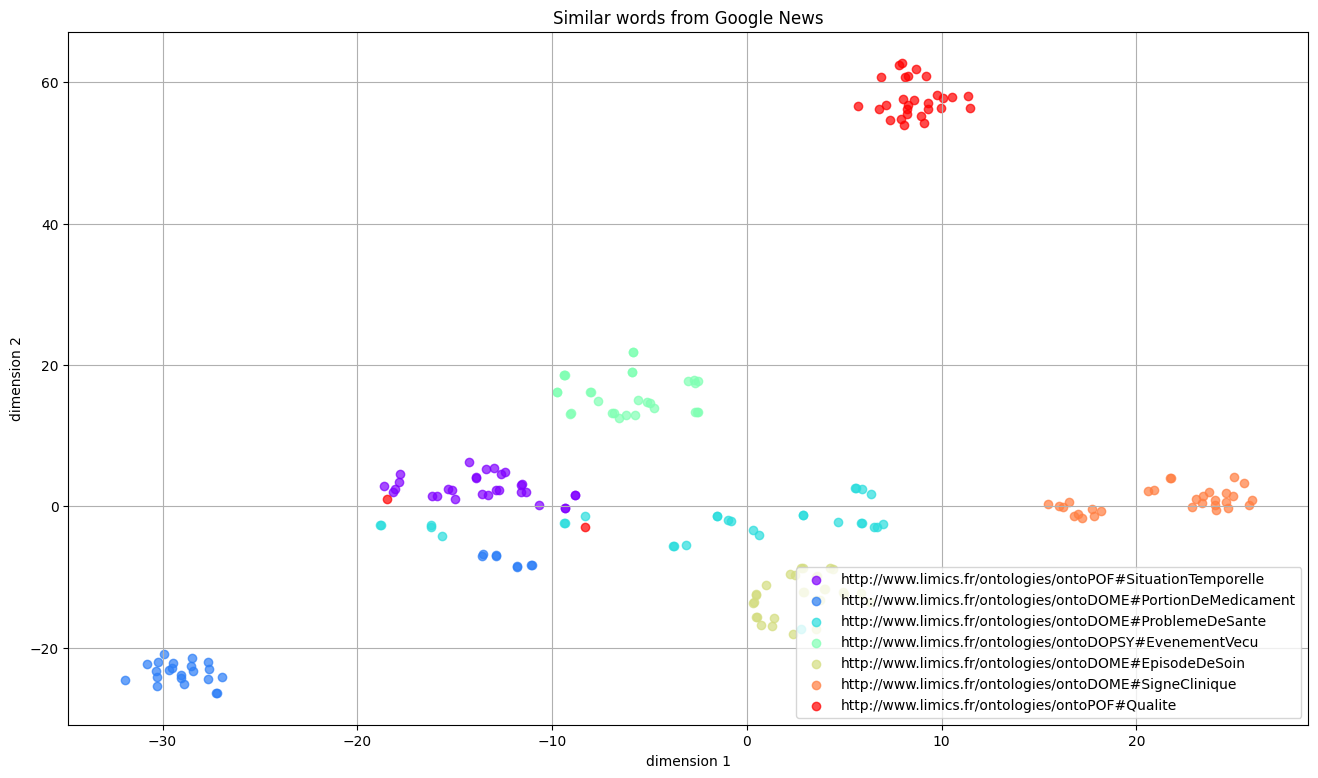

In [28]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.grid(True)
    plt.show()


tsne_plot_similar_words('Similar words from embedding', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

As explained [above](#tsne) in brief, lets see how the plot varies wrt changing perplexity.

```P = 50```

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/2815840799.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


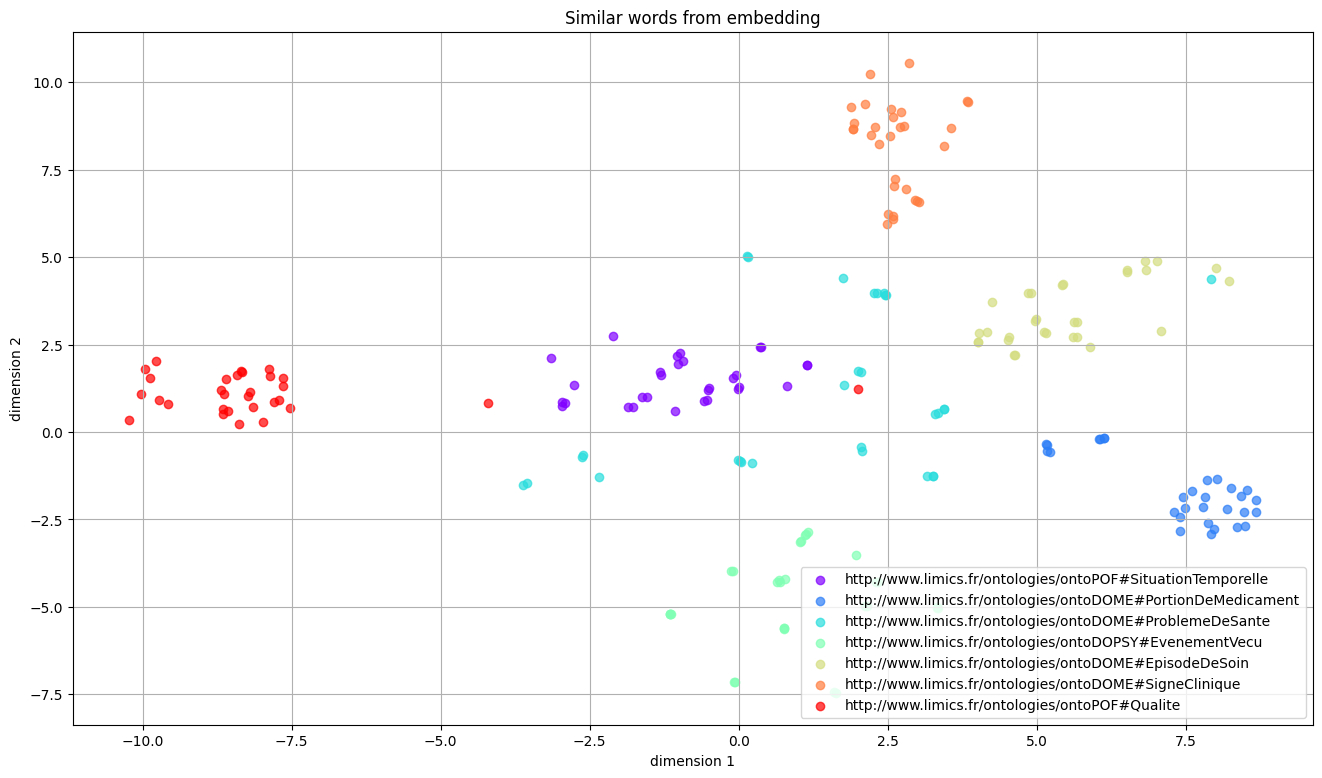

In [29]:
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from embedding', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

```P = 100```

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/3893161848.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


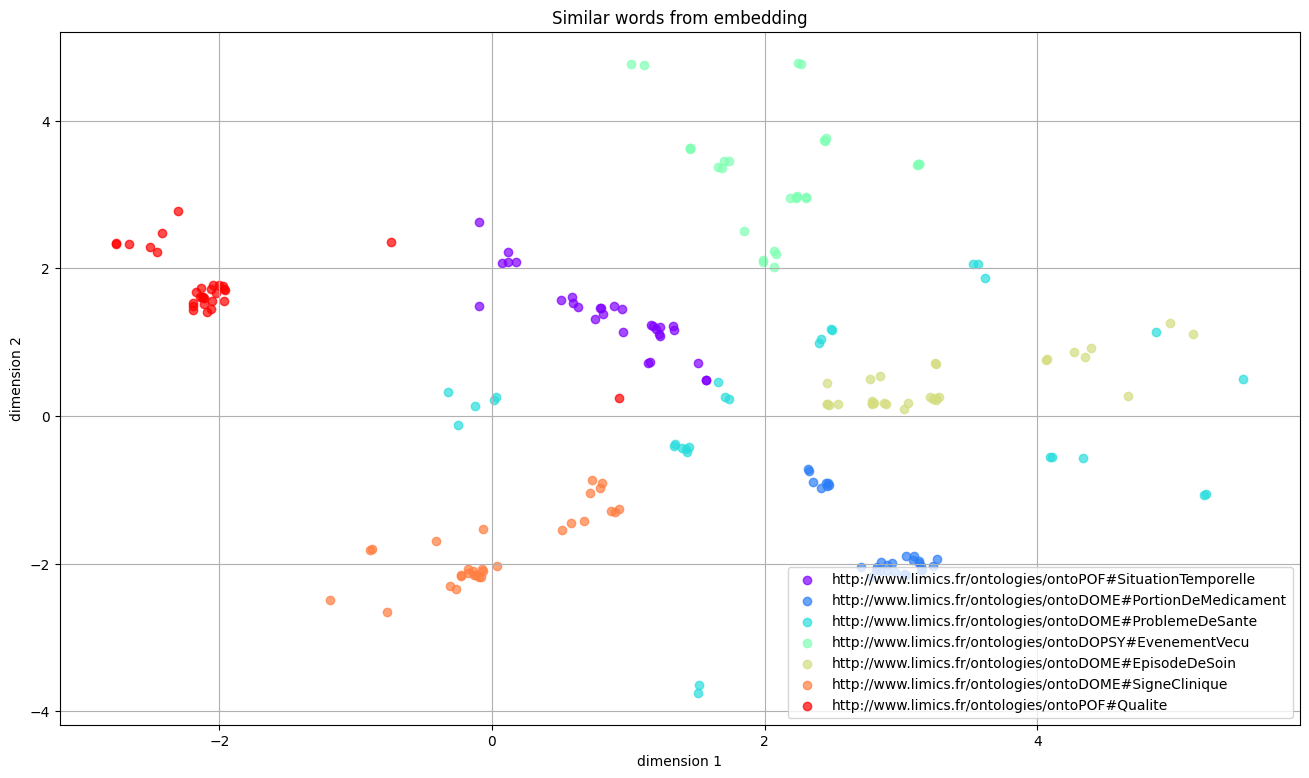

In [30]:
tsne_model_en_2d = TSNE(perplexity=100, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from embedding', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

```P = 200```

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/1857142137.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


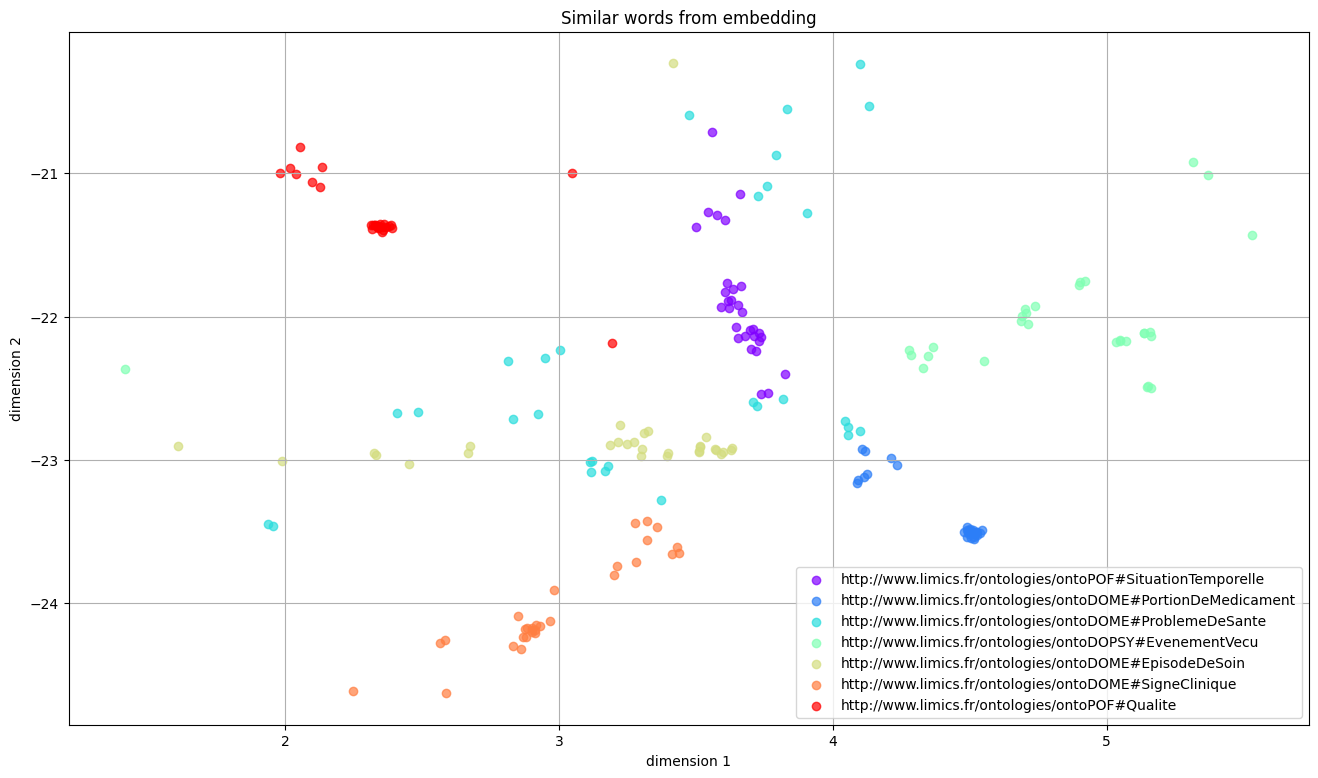

In [31]:
tsne_model_en_2d = TSNE(perplexity=150, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from embedding', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

# Visualizing the 3D Embeddings

```P = 500```

/var/folders/3h/7mq2_z6153b8fz44yc7l1klm0000gn/T/ipykernel_79927/1568875905.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=color, alpha=a, label=label)  # Plot in 3D


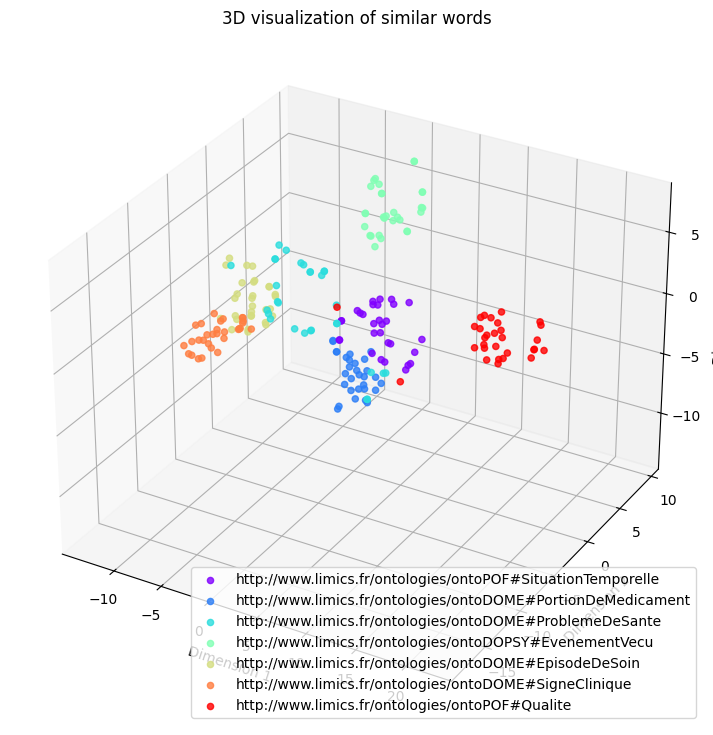

In [33]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Your original 3D array of embeddings: embedding_clusters with shape (n, m, k)
n, m, k = embedding_clusters.shape

# Initialize t-SNE with 3 components for 3D visualization
tsne_model_en_3d = TSNE(perplexity=15, n_components=3, init='pca', n_iter=3500, random_state=32)

# Reshape your embeddings to 2D array, fit_transform with t-SNE, and then reshape back to (n, m, 3) for 3D coordinates
embeddings_en_3d = np.array(tsne_model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 3)

def tsne_plot_similar_words_3d(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111, projection='3d')  # Set up a 3D projection
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        z = embeddings[:, 2]  # Extract the z-coordinate for 3D plotting
        ax.scatter(x, y, z, c=color, alpha=a, label=label)  # Plot in 3D
    ax.legend(loc=4)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")  # Label for the third dimension
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

# Ensure your t-SNE embeddings are 3D before calling this function
tsne_plot_similar_words_3d('3D visualization of similar words', keys, embeddings_en_3d, word_clusters, 0.8, 'similar_words_3d.png')


**Inference:**

We know that the value of perplexity denotes how many neighbors will affect a point. Consider the 1st case where we set ```P = 15``` , this focuses the attention of t-SNE on preserving the distances to its 15 nearest neighbors and puts virtually no weight on preserving distances to the remaining points. 

Since the subset we chose is smaller, we see the plots starts to uncover the global structure quite well since each point will preserve distances to a large portion of the data set.

**It's the end!**
I hope that you will find this popular tool useful in your tasks!

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Assuming original_embeddings and fine_tuned_embeddings are your embeddings
# and that they are aligned (i.e., the i-th element in each array corresponds to the same word)
original_embeddings='/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/w2v-fr/wiki+medical_model.word2vec'
fine_tuned_embeddings='/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/cache/output_fr/ontology.embeddings'

original_model = Word2Vec.load("/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/w2v-fr/wiki+medical_model.word2vec")
fine_tuned_model = Word2Vec.load("/Users/oaouina/Applications/pythonProject/OWL2Vec-Star/cache/output_fr/ontology.embeddings")


N = 1000  # Adjust N to your needs
# Assuming you've loaded your models as original_model and fine_tuned_model

# Assuming you want to visualize a subset of words common in both models
common_words = set(original_model.wv.index_to_key).intersection(set(fine_tuned_model.wv.index_to_key))
#print(common_words)
# Extract the vectors for these words from both models
original_vectors = np.array([original_model.wv[word] for word in common_words])
fine_tuned_vectors = np.array([fine_tuned_model.wv[word] for word in common_words])

# Combine the vectors for t-SNE
combined_embeddings = np.vstack((original_vectors, fine_tuned_vectors))

# Create labels for the plot
labels = ['Original'] * len(original_vectors) + ['Fine-Tuned'] * len(fine_tuned_vectors)

# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=42)

# Apply t-SNE to the combined embeddings
reduced_embeddings = tsne.fit_transform(combined_embeddings)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in zip(['Original', 'Fine-Tuned'], ['blue', 'red']):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], c=color, label=label)

plt.legend()
plt.title('t-SNE visualization of Original vs. Fine-Tuned Embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [ ]:
print("I'm done’)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Your original 3D array of embeddings: embedding_clusters with shape (n, m, k)
n, m, k = embedding_clusters.shape

# Initialize t-SNE with 3 components for 3D visualization
tsne_model_en_3d = TSNE(perplexity=15, n_components=3, init='pca', n_iter=3500, random_state=32)

# Reshape your embeddings to 2D array, fit_transform with t-SNE, and then reshape back to (n, m, 3) for 3D coordinates
embeddings_en_3d = np.array(tsne_model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 3)

def tsne_plot_similar_words_3d(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111, projection='3d')  # Set up a 3D projection
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        z = embeddings[:, 2]  # Extract the z-coordinate for 3D plotting
        ax.scatter(x, y, z, c=color, alpha=a, label=label)  # Plot in 3D
    ax.legend(loc=4)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")  # Label for the third dimension
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

# Ensure your t-SNE embeddings are 3D before calling this function
tsne_plot_similar_words_3d('3D visualization of similar words', keys, embeddings_en_3d, word_clusters, 0.7, 'similar_words_3d.png')
